In [22]:
import numpy as np
import pandas as pd
import igraph as ig
import numpy as np
import random
import matplotlib.pyplot as plt
np.random.seed(42)

In [84]:
filtered_network = pd.read_csv('../data_processed/filtered_cytokine_network.csv')

In [85]:
unfiltered_network = filtered_network.copy()
print(len(unfiltered_network))


2485


In [86]:
cytokines_to_remove = ['TGFb','IFNg']
mask_remove_cytokines = [(not filtered_network.iloc[i]['Source'] in cytokines_to_remove) and (not filtered_network.iloc[i]['Target'] in cytokines_to_remove) for i in range(len(filtered_network))]
filtered_network = filtered_network[mask_remove_cytokines]
print(len(filtered_network))

2304


In [29]:
def df_to_graph (data):
    edges = []
    actions = []
    mediators = []
    for _, row in data.iterrows():
        edges.append((row["Source"], row["Target"]))
        actions.append(row["action"])
        mediators.append(row['Mediators'])
    g = ig.Graph(directed=True)
    g.add_vertices(list(set(data["Source"]).union(set(data["Target"]))))
    g.add_edges(edges)
    g.es["action"] = actions
    g.es["Mediators"] = mediators
    return g
data = filtered_network
g = df_to_graph(data)
g_unfiltered = df_to_graph(unfiltered_network)

#### Creating the null graphs and saving them

In [30]:

def rewire_graph_unique_edges(g, p=1, n_swaps=None):
    # Step 1: Create initial graph from dataframe
    g_copy = g.copy()
    num_edges = g_copy.ecount()
    
    if n_swaps is None:
        n_swaps = int(p * num_edges)

    edge_data = [(e.source, e.target, e["action"]) for e in g_copy.es]
    
    # Step 3: Rewiring process while ensuring no duplicate edges of the same type
    for _ in range(n_swaps):
        i, j = random.sample(range(len(edge_data)), 2)
        u, v, action1 = edge_data[i]
        w, x, action2 = edge_data[j]

        # Only avoid adding duplicate action types for the same edge
        if (u, x, 'Positive') not in edge_data and (u, x, 'Negative') not in edge_data and (w, v, 'Positive') not in edge_data and (w, v, 'Negative') not in edge_data:
            edge_data[i] = (u, x, action1)
            edge_data[j] = (w, v, action2)

    # Step 5: Create final graph with unique edges and attributes
    new_graph = ig.Graph(directed=True)
    new_graph.add_vertices(g_copy.vs["name"])

    for (u, v,action) in edge_data:
        new_graph.add_edge(u, v, action = action)

    return new_graph



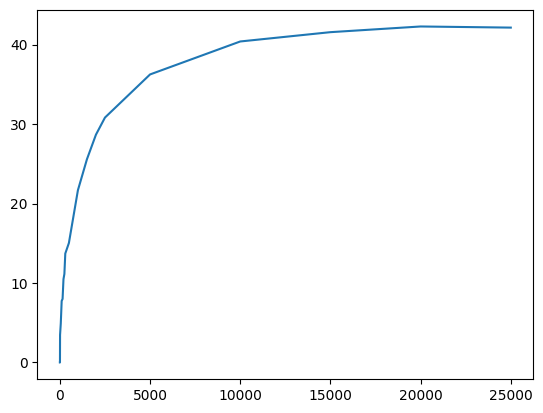

In [ ]:
#Checking how many swaps needed to get far enough from the original
n_swaps = [1,2,5,10,50,100,150,200,250,300,500,1000,1500,2000,2500,5000,10000,15000,20000,25000]
diffs = []
adj_orig = g_unfiltered.get_adjacency()

for n_swap in n_swaps:
    rw_g = rewire_graph_unique_edges(g_unfiltered, n_swaps=n_swap)
    adj2 = rw_g.get_adjacency()
    diff = np.linalg.norm(adj_orig-adj2)
    diffs.append(diff)

plt.plot(n_swaps,diffs)
plt.xlabel('Number of swaps')
plt.ylabel('Distance in L1 space')
n_swaps = 10000

Creating and saving the null graphs

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([  4.,   5.,  42., 120., 230., 293., 194.,  78.,  29.,   5.]),
 array([39.54743987, 39.77838579, 40.00933171, 40.24027763, 40.47122355,
        40.70216947, 40.93311539, 41.16406131, 41.39500723, 41.62595315,
        41.85689907]),
 <BarContainer object of 10 artists>)

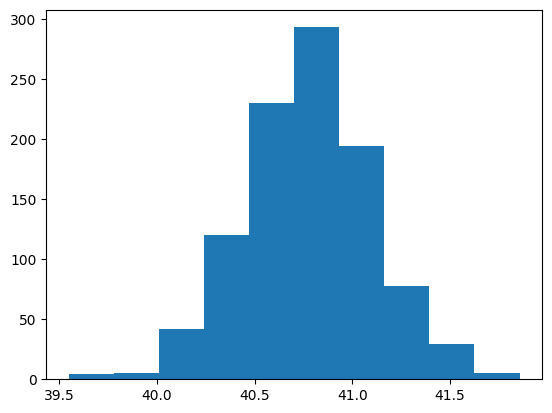

In [ ]:
num_randoms = 10000
random_graphs = []
diffs = []
adj1 = g_unfiltered.get_adjacency()
n_swaps = 10000
from tqdm.notebook import tqdm

for i in tqdm(range(num_randoms)):
    random_graph = rewire_graph_unique_edges(g_unfiltered,n_swaps=n_swaps)
    random_graphs.append(random_graph)
    adj2 = random_graph.get_adjacency()
    diff = np.linalg.norm(adj1-adj2)
    diffs.append(diff)
plt.hist(diffs)

In [37]:
mask_pos_orig = [action == 'Positive' for action in g_unfiltered.es['action']]
num_pos_orig = len(np.array(g_unfiltered.es['action'])[mask_pos_orig])
print(num_pos_orig)
flag = True
for rw_g in random_graphs:
    actions = rw_g.es['action']
    mask_pos = [action == 'Positive' for action in actions]
    actions_pos = np.array(actions)[mask_pos]
    if len(actions_pos)!=num_pos_orig:
        print("Rewired wrong - not all graphs has the same amount of positive and negative interactions")
        flag = False
        break
if flag: print("all graphs has the same amount of positive and negative interactions")


2382
all graphs has the same amount of positive and negative interactions


### Finding and counting excitable motifs

In [38]:
def count_excitable_motif (g):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    motif.add_edges([(0, 0), (0, 1), (1, 0)])  # A → A, A → B, B → A
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    filtered_count = 0
    # Step 5: Count motifs that match the action pattern
    filtered_count = 0
    for match in matches:
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        # Ensure the edges exist and fetch their actions
        if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):
            edge_1_id = g.get_eid(a, a)
            edge_2_id = g.get_eid(a, b)
            edge_3_id = g.get_eid(b, a)
            e1 = g.es[edge_1_id]
            e2 = g.es[edge_2_id]
            e3 = g.es[edge_3_id]
            if e1['action']=='Positive' and e2['action']=='Positive' and e3['action']=='Negative':
                filtered_count +=1
    return filtered_count


def find_excitable_motif (g,verbose = False):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    motif.add_edges([(0, 0), (0, 1), (1, 0)])  # A → A, A → B, B → A
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    # Step 5: Count motifs that match the action pattern
    filtered_count = 0
    edges = []
    mediators = []
    for match in matches:
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        if verbose:
            print(a,b)
        # Ensure the edges exist and fetch their actions
        if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):
            edge_1_id = g.get_eid(a, a)
            edge_2_id = g.get_eid(a, b)
            edge_3_id = g.get_eid(b, a)
            if verbose:
                print(g.es[edge_1_id]['df'][['Source','Target','action','Mediator']])
                print(g.es[edge_2_id]['df'][['Source','Target','action','Mediator']])
                print(g.es[edge_3_id]['df'][['Source','Target','action','Mediator']])
            e1 = g.es[edge_1_id]
            e2 = g.es[edge_2_id]
            e3 = g.es[edge_3_id]

            if e1['action']=='Positive' and e2['action']=='Positive' and e3['action']=='Negative':
                filtered_count+=1
                edges.append((a,b))
                mediators.append((e1['Mediators'],e2['Mediators'],e3['Mediators']))

    #print("Number of matching motifs:", filtered_count)
    return filtered_count,edges,mediators

def find_excitable_motif_mod (g):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    motif.add_edges([(0, 0), (0, 1), (1, 0), (1,1)])  # A → A, A → B, B → A
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    # Step 5: Count motifs that match the action pattern
    filtered_count = 0
    edges = []
    mediators = []
    for match in matches:
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        # Ensure the edges exist and fetch their actions
        if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):
            edge_1_id = g.get_eid(a, a)
            edge_2_id = g.get_eid(a, b)
            edge_3_id = g.get_eid(b, a)
            edge_4_id = g.get_eid(b, b)
            e1 = g.es[edge_1_id]
            e2 = g.es[edge_2_id]
            e3 = g.es[edge_3_id]
            e4 = g.es[edge_4_id]

            if e1['action']=='Positive' and e2['action']=='Positive' and e3['action']=='Negative' and e4['action']=='Negative':
                filtered_count+=1
                edges.append((a,b))
                mediators.append((e1['Mediators'],e2['Mediators'],e3['Mediators'],e4['Mediators']))
    #print("Number of matching motifs:", filtered_count)
    return filtered_count,edges,mediators

def count_excitable_motif_b (g):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    motif.add_edges([(0, 0), (0, 1), (1, 0)])  # A → A, A → B, B → A
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    filtered_count = 0
    # Step 5: Count motifs that match the action pattern
    filtered_count = 0
    for match in matches:
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        
        # Ensure the edges exist and fetch their actions
        if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):
            edge_1_id = g.get_eid(a, a)
            edge_2_id = g.get_eid(a, b)
            edge_3_id = g.get_eid(b, a)

            e1 = g.es[edge_1_id]
            e2 = g.es[edge_2_id]
            e3 = g.es[edge_3_id]

            if e1['action']=='Positive' and e2['action']=='Negative' and e3['action']=='Positive':
                filtered_count+=1
    #print("Number of matching motifs:", filtered_count)
    return filtered_count

def find_excitable_motif_b (g):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    motif.add_edges([(0, 0), (0, 1), (1, 0)])  # A → A, A → B, B → A
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    # Step 5: Count motifs that match the action pattern
    filtered_count = 0
    edges = []
    mediators = []
    for match in matches:
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        
        # Ensure the edges exist and fetch their actions
        if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):
            edge_1_id = g.get_eid(a, a)
            edge_2_id = g.get_eid(a, b)
            edge_3_id = g.get_eid(b, a)

            e1 = g.es[edge_1_id]
            e2 = g.es[edge_2_id]
            e3 = g.es[edge_3_id]
            if e1['action']=='Positive' and e2['action']=='Negative' and e3['action']=='Positive':
                filtered_count+=1
                edges.append((a,b))
                mediators.append((e1['Mediators'],e2['Mediators'],e3['Mediators']))

    #print("Number of matching motifs:", filtered_count)
    return filtered_count,edges,mediators


Finding and printing all excitable motifs in original graph

In [40]:
count,edges,mediators = find_excitable_motif(g_unfiltered)
for edge,mediator_couple in zip(edges,mediators):
    print(f'{edge[0]}<-({mediator_couple[0]})->{edge[0]}-({mediator_couple[1]})->{edge[1]}-({mediator_couple[2]})-|{edge[0]}')
print(count)

BAFF<-(B)->BAFF-(B)->IL10-(DC, Macrophage)-|BAFF
CCL21<-(DC)->CCL21-(B, DC)->IL10-(DC)-|CCL21
CCL21<-(DC)->CCL21-(DC)->IL37-(DC)-|CCL21
CCL3<-(Monocyte, NK)->CCL3-(DC, Monocyte)->IL37-(Monocyte)-|CCL3
CCL4<-(Macrophage, Monocyte, NK)->CCL4-(B, DC, Macrophage, Th1)->IL10-(Macrophage)-|CCL4
CCL4<-(Macrophage, Monocyte, NK)->CCL4-(DC, Monocyte)->IL37-(Monocyte)-|CCL4
IL25<-(Mast, Th2)->IL25-(Th2)->TGFb-(Th2)-|IL25
IL2<-(T_CD4, T_CD8)->IL2-(T_reg)->TGFb-(T_CD4, Th1)-|IL2
IL2<-(T_CD4, T_CD8)->IL2-(B, T_reg)->IL10-(T_CD4)-|IL2
IL2<-(T_CD4, T_CD8)->IL2-(B, T_reg)->IL35-(T_CD4)-|IL2
IL3<-(Eosinophil, Mast)->IL3-(Eosinophil)->TGFb-(Th1, Th2)-|IL3
IL1b<-(Macrophage)->IL1b-(Macrophage)->IL10-(DC, Macrophage)-|IL1b
IL13<-(Basophil, Th2)->IL13-(DC, Eosinophil, Th2)->TGFb-(Th2)-|IL13
IL6<-(B, Macrophage, Monocyte, pDC)->IL6-(B, Macrophage, Th17)->IL10-(DC, Macrophage)-|IL6
IL6<-(B, Macrophage, Monocyte, pDC)->IL6-(Monocyte)->IL37-(DC, Monocyte)-|IL6
CCL18<-(DC)->CCL18-(DC)->IL37-(DC)-|CCL18
CCL18<-(

/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_88948/2401340699.py:40: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


In [41]:
count_b,edges_b,mediators_b = find_excitable_motif_b(g_unfiltered)


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_88948/2401340699.py:131: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_88948/2401340699.py:13: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


46
2
Significance of excitable motif in original graph (p-value): 0.002


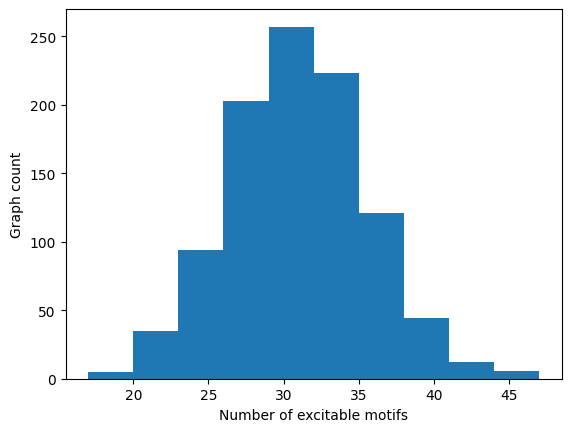

In [43]:
thrsh = count_excitable_motif(g_unfiltered)
print(thrsh)
num_excitable_motifs = []
for random_graph in random_graphs:
    num_excitable_motifs.append(count_excitable_motif(random_graph))
num_excitable_motifs = np.array(num_excitable_motifs)
plt.hist(num_excitable_motifs)
plt.xlabel('Number of excitable motifs')
plt.ylabel('Graph count')
print(len(num_excitable_motifs[num_excitable_motifs>=thrsh]))
print("Significance of excitable motif in original graph (p-value):",len(num_excitable_motifs[num_excitable_motifs>=thrsh])/len(random_graphs))

/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_88948/2401340699.py:103: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


35
224
Significance of type-B excitable motif in original graph (p-value): 0.224


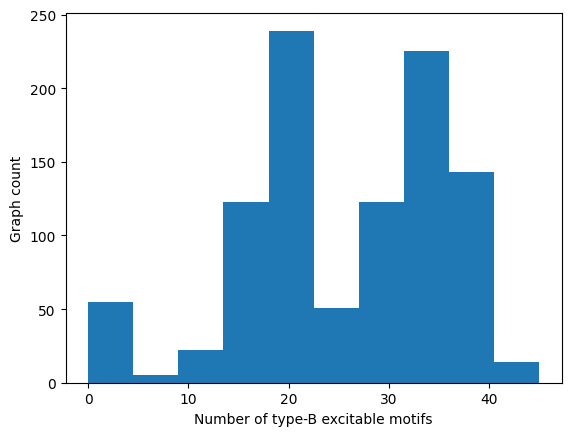

In [44]:
thrsh = count_excitable_motif_b(g_unfiltered)
print(thrsh)
num_excitable_motifs = []
for random_graph in random_graphs:
    num_excitable_motifs.append(count_excitable_motif_b(random_graph))
num_excitable_motifs = np.array(num_excitable_motifs)
plt.hist(num_excitable_motifs)
plt.xlabel('Number of type-B excitable motifs')
plt.ylabel('Graph count')
print(len(num_excitable_motifs[num_excitable_motifs>=thrsh]))
print("Significance of type-B excitable motif in original graph (p-value):",len(num_excitable_motifs[num_excitable_motifs>=thrsh])/len(random_graphs))

/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_88948/2401340699.py:13: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


46
0
0.0
0
0.0
2
0.004
1
0.001
4
0.002
9
0.0018
0
0.0


(array([  6.,  35.,  67., 119., 251., 253., 132.,  90.,  40.,   7.]),
 array([17. , 19.7, 22.4, 25.1, 27.8, 30.5, 33.2, 35.9, 38.6, 41.3, 44. ]),
 <BarContainer object of 10 artists>)

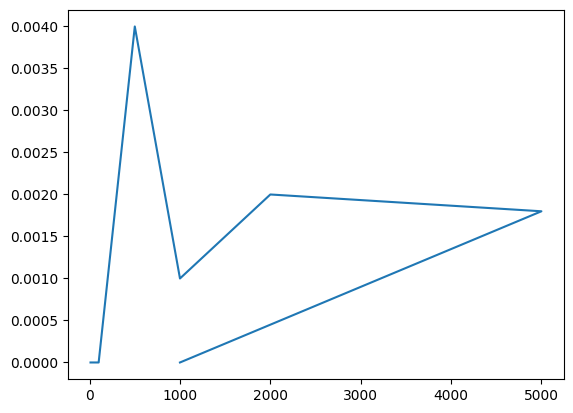

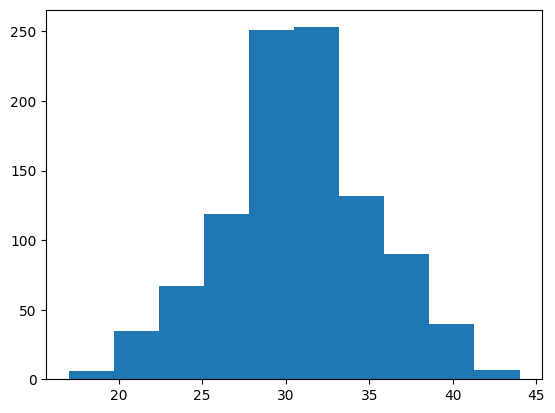

In [45]:
p_values = []
thrsh = count_excitable_motif(g_unfiltered)
print(thrsh)
nums_random_to_check = [10,100,500,1000,2000,5000,len(random_graphs)]
for num_random in nums_random_to_check:
    random_graphs_to_check = np.random.choice(random_graphs,num_random)
    num_excitable_motifs = []
    for random_graph in random_graphs_to_check:
        num_excitable_motifs.append(count_excitable_motif(random_graph))
    num_excitable_motifs = np.array(num_excitable_motifs)
    print(len(num_excitable_motifs[num_excitable_motifs>=thrsh]))
    print(len(num_excitable_motifs[num_excitable_motifs>=thrsh])/len(random_graphs_to_check))
    p_values.append(len(num_excitable_motifs[num_excitable_motifs>=thrsh])/len(random_graphs_to_check))
fig,ax = plt.subplots()
ax.plot(nums_random_to_check,p_values)

fig,ax = plt.subplots()
ax.hist(num_excitable_motifs)


### Counting all motifs and and finding significance

In [46]:
def create_motif_from_str (motif_str):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    for i,ch in enumerate(motif_str):
        if i==0 and ch!='0':
            motif.add_edge(0,0)
        if i==1 and ch!='0':
            motif.add_edge(0,1)
        if i==2 and ch!='0':
            motif.add_edge(1,1)
        if i==3 and ch!='0':
            motif.add_edge(1,0)
    return motif

def char_to_action (char):
    if char=='1': 
        return 'Positive'
    elif char=='2':
        return 'Negative'
    else: return ''
        
def count_motif_no_multiple_edges (g,motif_str):
    motif = create_motif_from_str(motif_str)
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    filtered_count = 0
    for match in matches:
        add = 1
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        for i,ch in enumerate(motif_str):
            if i==0 and ch!='0':
                edge_id = g.get_eid(a, a)
                add *= int(g.es[edge_id]['action']==char_to_action(ch))
            if i==1 and ch!='0':
                edge_id = g.get_eid(a, b)
                add *= int(g.es[edge_id]['action']==char_to_action(ch))
            if i==2 and ch!='0':
                edge_id = g.get_eid(b, b)
                add *= int(g.es[edge_id]['action']==char_to_action(ch))
            if i==3 and ch!='0':
                edge_id = g.get_eid(b, a)
                add *= int(g.es[edge_id]['action']==char_to_action(ch))
        filtered_count+=add
    return filtered_count

def count_random_graphs_motif (data,motif_str, num_randoms,p = 0.999):
    num_motifs = np.zeros(shape = num_randoms)
    for i in range(num_randoms):
        random_graph = rewire_graph_unique_edges(data,p)
        count = count_motif_no_multiple_edges(random_graph,motif_str)
        num_motifs[i] = count
    return num_motifs


In [79]:
motif_strs = []
for i0 in range(3):
    for i1 in range(3):
        for i2 in range(3):
            for i3 in range(3):
                if i1==0 and i3==0:
                    continue
                motif_str = str(i0)+str(i1)+str(i2)+str(i3)
                motif_str_reversed = str(i2)+str(i3)+str(i0)+str(i1)
                if motif_str_reversed not in motif_strs:
                    motif_strs.append(motif_str)
motifs_count_in_original_graph = []
motif_average_in_rewired_graphs = []
motif_std_in_rewired_graphs = []
p_value_in_rewired_graphs = []
#motif_counts_in_rewired_graphs = []
motif_zscores = []
for motif_str in motif_strs:
    print("motif str:",motif_str)
    thrsh = count_motif_no_multiple_edges(g_unfiltered,motif_str)
    motifs_count_in_original_graph.append(thrsh)
    print("motif count in original graph:",thrsh)
    num_motifs = np.array([count_motif_no_multiple_edges(r_g,motif_str) for r_g in random_graphs])
    motif_average_in_rewired_graphs.append(np.array(num_motifs).mean())
    motif_std_in_rewired_graphs.append(np.array(num_motifs).std())
    print("mean motif count in rewired graphs:",np.array(num_motifs).mean())
    print("motif sd in rewired graphs:",np.array(num_motifs).std())
    print("p value: ",len(num_motifs[num_motifs>thrsh])/len(num_motifs))
    p_value_in_rewired_graphs.append(len(num_motifs[num_motifs>=thrsh])/len(num_motifs))
    #motif_counts_in_rewired_graphs.append(num_motifs)
    motif_zscores.append((thrsh-np.array(num_motifs).mean())/(np.array(num_motifs).std()))
motifs_df = pd.DataFrame({'motif':motif_strs,'count in original graph':motifs_count_in_original_graph,'mean count in rewired graphs':motif_average_in_rewired_graphs,
                          'sd count in rewired graphs':motif_std_in_rewired_graphs,'p value':p_value_in_rewired_graphs,'z score':motif_zscores})
motifs_df.sort_values(by = 'count in original graph',ascending=False)
motifs_df

motif str: 0001
motif count in original graph: 2340
mean motif count in rewired graphs: 2359.845
motif sd in rewired graphs: 2.752630560027989
p value:  1.0
motif str: 0002
motif count in original graph: 101
mean motif count in rewired graphs: 101.54
motif sd in rewired graphs: 0.8742997197757757
p value:  0.562
motif str: 0011
motif count in original graph: 1209
mean motif count in rewired graphs: 778.531
motif sd in rewired graphs: 83.23020508805682
p value:  0.0
motif str: 0012
motif count in original graph: 62
mean motif count in rewired graphs: 46.038
motif sd in rewired graphs: 16.63738428960514
p value:  0.115
motif str: 0021
motif count in original graph: 34
mean motif count in rewired graphs: 14.11
motif sd in rewired graphs: 18.507941538701704
p value:  0.151
motif str: 0022
motif count in original graph: 37
mean motif count in rewired graphs: 36.279
motif sd in rewired graphs: 20.23386169271699
p value:  0.267
motif str: 0101
motif count in original graph: 488
mean motif cou

,motif,count in original graph,mean count in rewired graphs,sd count in rewired graphs,p value,z score
0,0001,2340,2359.845,2.752631,1.000,-7.209467
1,0002,101,101.540,0.874300,0.885,-0.617637
2,0011,1209,778.531,83.230205,0.000,5.172029
3,0012,62,46.038,16.637384,0.396,0.959406
4,0021,34,14.110,18.507942,0.307,1.074674
5,0022,37,36.279,20.233862,0.381,0.035633
6,0101,488,455.844,14.322279,0.012,2.245173
7,0102,52,50.900,3.980955,0.435,0.276316
8,0110,1455,945.050,102.762170,0.000,4.962429
9,0111,445,291.607,27.169957,0.000,5.645684
